# High In-Degree Neurons Analysis

This notebook identifies neurons with high in-degree from the Hemibrain dataset and creates visualizations to determine appropriate thresholds.

Code adapted from:
- `oviIN_specs_rankings.ipynb`: Fetching traced neurons
- `mesoscale_connectivity.ipynb`: Understanding neuron connectivity

## Setup and Imports

In [12]:
import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger().setLevel(logging.ERROR)

In [3]:
!pip install neuprint-python

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 5.9 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5031 sha256=93d4e95f412717a99dbcc23226c607046a1df4a1790cd5626da13ffd44d8196e
  Stored in directory: /root/.cache/pip/wheels/a5/d7/98/f56ae733748cd0fa577172bda0e73e0b1f1793c98e09b9e458
Successfully built asciitree


In [4]:
# Imports - adapted from oviIN_specs_rankings.ipynb (lines 34-62)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from neuprint import Client, fetch_neurons, NeuronCriteria as NC
import warnings

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

# Matplotlib settings
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
%matplotlib inline

print("Imports complete")

Imports complete


## Connect to Neuprint
Adapted from `oviIN_specs_rankings.ipynb` (lines 17-26)

In [7]:
# Read authentication token
from google.colab import userdata
auth_token = userdata.get('NEUPRINT_TOKEN')

# Connect to Neuprint
np_client = Client(
    'neuprint.janelia.org',
    dataset='hemibrain:v1.2.1',
    token=auth_token
)
version = np_client.fetch_version()

print(f"Connected to neuprint.janelia.org")
print(f"  Dataset: hemibrain:v1.2.1")
print(f"  Version: {version}")

Connected to neuprint.janelia.org
  Dataset: hemibrain:v1.2.1
  Version: 1.7.10


## Fetch All Traced Neurons
Adapted from `oviIN_specs_rankings.ipynb` (lines 222-300)

Fetch neurons with:
- `status='Traced'`: Fully reconstructed neurons
- `cropped=False`: Not cut off at volume boundaries

The `upstream` field = in-degree (number of presynaptic partners)

In [9]:
# Define criteria for traced, non-cropped neurons
criteria = NC(status='Traced', cropped=False)

print("Fetching neurons")
neurons_df, roi_counts = fetch_neurons(criteria, client=np_client)

print(f"\nFetched {len(neurons_df):,} traced neurons")
print(f"\nColumns: {list(neurons_df.columns[:10])}...")
print(f"\nFirst 5 neurons:")
neurons_df[['bodyId', 'instance', 'type', 'pre', 'post', 'upstream']].head()

Fetching neurons

Fetched 21,739 traced neurons

Columns: ['bodyId', 'instance', 'type', 'pre', 'post', 'downstream', 'upstream', 'mito', 'size', 'status']...

First 5 neurons:


,bodyId,instance,type,pre,post,upstream
0,200326126,CL141_L,CL141,395,1068,1068
1,202916528,FS4C(FQ12)_C4_R,FS4C,95,431,431
2,203253072,FS4A(AB)(FQ12)_C3_R,FS4A,62,366,366
3,203253253,SMP505(PDM22)_L,SMP505,415,3112,3112
4,203257652,FS4C(FQ12)_C6_R,FS4C,65,270,270


## Calculate In-Degree Statistics

In [10]:
# Extract in-degree values (upstream = number of presynaptic partners)
indegree_values = neurons_df['upstream'].values

# Calculate statistics
stats = {
    'n_neurons': len(neurons_df),
    'mean': np.mean(indegree_values),
    'median': np.median(indegree_values),
    'std': np.std(indegree_values),
    'min': np.min(indegree_values),
    'max': np.max(indegree_values),
    'q25': np.percentile(indegree_values, 25),
    'q75': np.percentile(indegree_values, 75),
    'q90': np.percentile(indegree_values, 90),
    'q95': np.percentile(indegree_values, 95),
    'q99': np.percentile(indegree_values, 99)
}

# Print statistics
print(f"Total neurons: {stats['n_neurons']:,}")
print(f"\nIn-degree statistics:")
print(f"  Mean:     {stats['mean']:.1f}")
print(f"  Median:   {stats['median']:.1f}")
print(f"  Std Dev:  {stats['std']:.1f}")
print(f"  Min:      {stats['min']:.0f}")
print(f"  Max:      {stats['max']:.0f}")
print(f"\nKey percentiles:")
print(f"  75th:     {stats['q75']:.0f}")
print(f"  90th:     {stats['q90']:.0f}")
print(f"  95th:     {stats['q95']:.0f}")
print(f"  99th:     {stats['q99']:.0f}")

Total neurons: 21,739

In-degree statistics:
  Mean:     871.6
  Median:   494.0
  Std Dev:  1818.0
  Min:      2
  Max:      127151

Key percentiles:
  75th:     856
  90th:     1766
  95th:     2838
  99th:     6926


## Visualize Distribution

Four complementary views:
1. **Linear histogram**: Overall shape
2. **Log histogram**: Better view of full range
3. **CDF**: Cumulative distribution (easy to read percentiles)
4. **Box plot**: Compact summary

<Figure size 1600x1200 with 0 Axes>

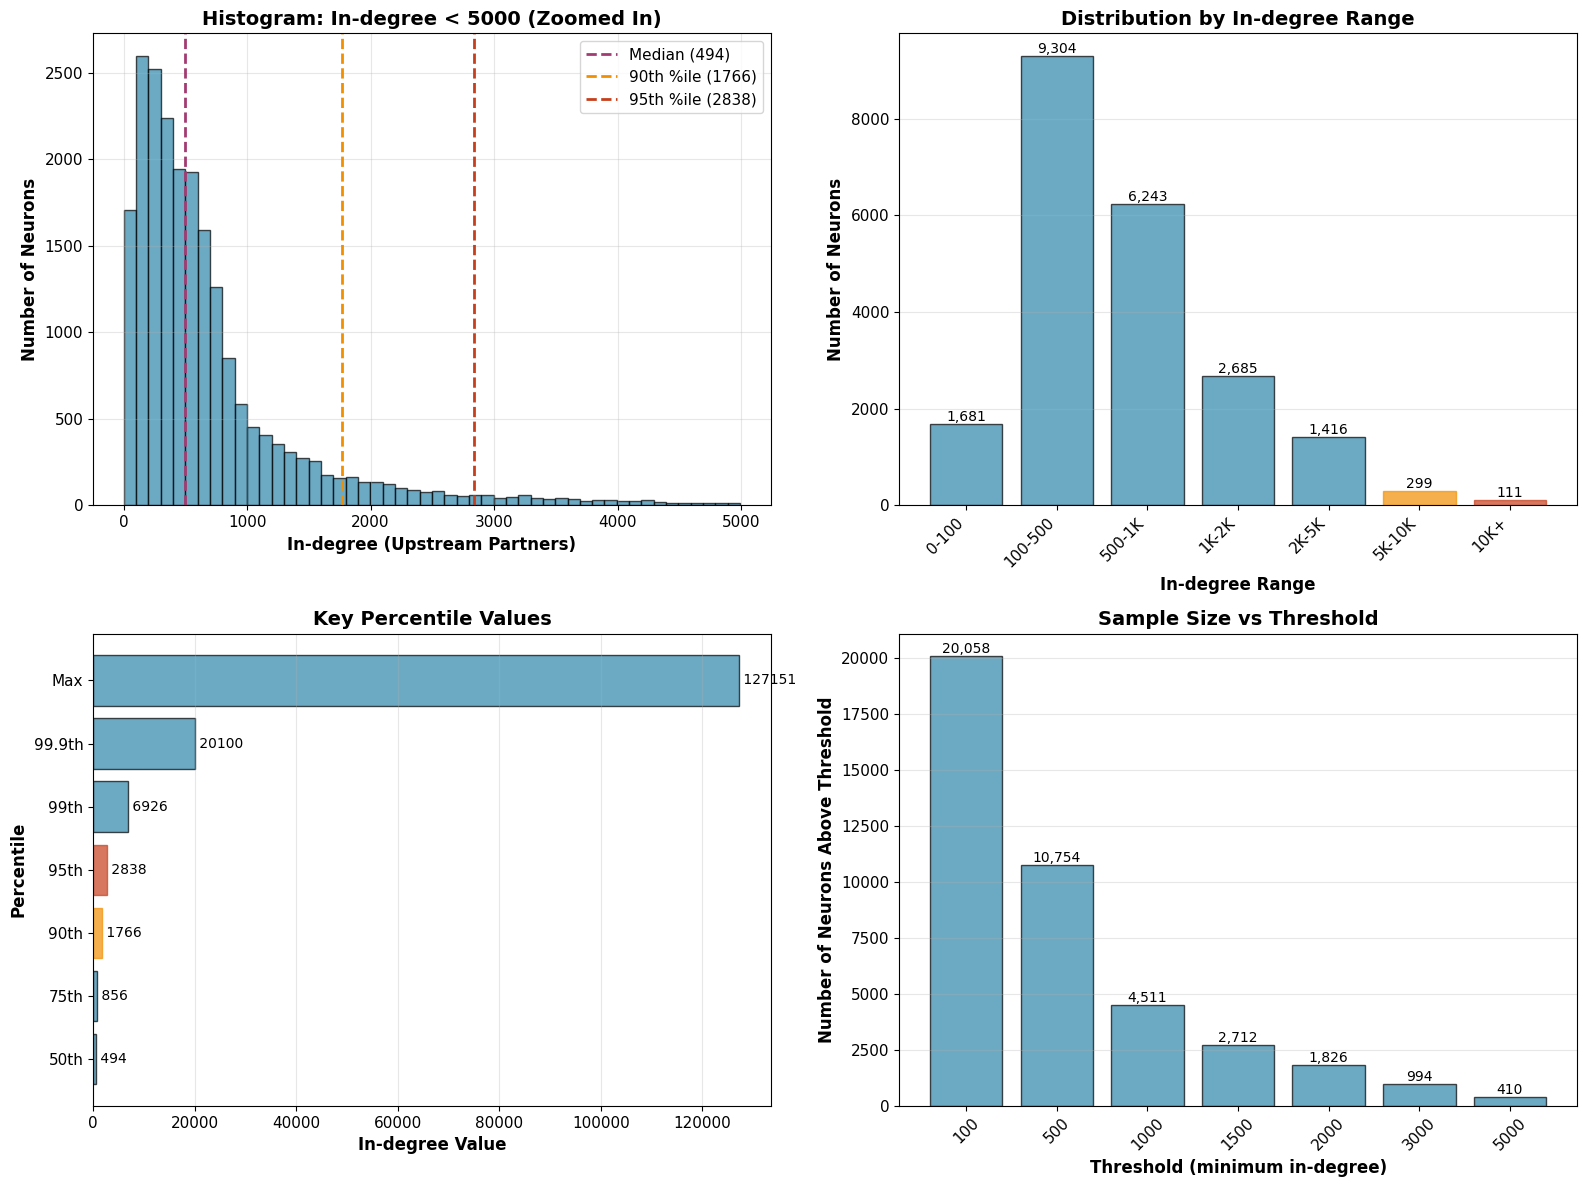

In [14]:
# Create 4-panel figure
fig = plt.figure(figsize=(16, 12))

# Colors for consistency
colors = {
    'primary': '#2E86AB',
    'median': '#A23B72',
    'q90': '#F18F01',
    'q95': '#C73E1D'
}

# Create interpretable histogram
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Panel 1: Histogram with reasonable bins (focus on the bulk of data)
ax1 = axes[0, 0]
# Focus on neurons with in-degree < 5000 to see the structure better
mask = indegree_values < 5000
ax1.hist(indegree_values[mask], bins=50, color=colors['primary'], alpha=0.7, edgecolor='black')
ax1.axvline(stats['median'], color=colors['median'], linestyle='--', linewidth=2, label=f"Median ({stats['median']:.0f})")
ax1.axvline(stats['q90'], color=colors['q90'], linestyle='--', linewidth=2, label=f"90th %ile ({stats['q90']:.0f})")
ax1.axvline(stats['q95'], color=colors['q95'], linestyle='--', linewidth=2, label=f"95th %ile ({stats['q95']:.0f})")
ax1.set_xlabel('In-degree (Upstream Partners)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Neurons', fontsize=12, fontweight='bold')
ax1.set_title('Histogram: In-degree < 5000 (Zoomed In)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Panel 2: Histogram by ranges (categorical)
ax2 = axes[0, 1]
bins_edges = [0, 100, 500, 1000, 2000, 5000, 10000, np.inf]
bins_labels = ['0-100', '100-500', '500-1K', '1K-2K', '2K-5K', '5K-10K', '10K+']
counts, _ = np.histogram(indegree_values, bins=bins_edges)
bars = ax2.bar(bins_labels, counts, color=colors['primary'], alpha=0.7, edgecolor='black')
# Highlight the high in-degree ranges
bars[-1].set_color(colors['q95'])
bars[-2].set_color(colors['q90'])
ax2.set_xlabel('In-degree Range', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Neurons', fontsize=12, fontweight='bold')
ax2.set_title('Distribution by In-degree Range', fontsize=14, fontweight='bold')
ax2.tick_labels = ax2.set_xticklabels(bins_labels, rotation=45, ha='right')
ax2.grid(True, alpha=0.3, axis='y')
# Add counts on top of bars
for i, (bar, count) in enumerate(zip(bars, counts)):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{count:,}',
             ha='center', va='bottom', fontsize=10)

# Panel 3: Percentile breakdown
ax3 = axes[1, 0]
percentiles = [50, 75, 90, 95, 99, 99.9, 100]
percentile_values = [np.percentile(indegree_values, p) for p in percentiles]
percentile_labels = ['50th', '75th', '90th', '95th', '99th', '99.9th', 'Max']
bars = ax3.barh(percentile_labels, percentile_values, color=colors['primary'], alpha=0.7, edgecolor='black')
bars[2].set_color(colors['q90'])  # Highlight 90th
bars[3].set_color(colors['q95'])  # Highlight 95th
ax3.set_xlabel('In-degree Value', fontsize=12, fontweight='bold')
ax3.set_ylabel('Percentile', fontsize=12, fontweight='bold')
ax3.set_title('Key Percentile Values', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')
# Add values at end of bars
for bar, val in zip(bars, percentile_values):
    ax3.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f' {val:.0f}',
             va='center', fontsize=10)

# Panel 4: Sample sizes at different thresholds
ax4 = axes[1, 1]
thresholds_viz = [100, 500, 1000, 1500, 2000, 3000, 5000]
sample_sizes = [np.sum(indegree_values >= t) for t in thresholds_viz]
bars = ax4.bar([str(t) for t in thresholds_viz], sample_sizes, color=colors['primary'], alpha=0.7, edgecolor='black')
ax4.set_xlabel('Threshold (minimum in-degree)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Number of Neurons Above Threshold', fontsize=12, fontweight='bold')
ax4.set_title('Sample Size vs Threshold', fontsize=14, fontweight='bold')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3, axis='y')
# Add counts on bars
for bar, count in zip(bars, sample_sizes):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{count:,}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## Interpretation of Results

The in-degree distribution of Hemibrain traced neurons (n=21,739) is highly right-skewed, with a median of 494 and mean of 872 upstream partners. The majority of neurons (78%) have fewer than 1,000 presynaptic partners, while a small subset exhibits hub-like connectivity. The distribution shows a clear separation around 2,000 upstream partners, above which only 8% of neurons remain. For subsequent modularity maximization analysis, recommend using the **95th percentile (2,838 upstream partners) as the threshold for "high in-degree" neurons**, which yields approximately 1,087 neurons. This threshold is statistically rigorous, computationally manageable, and captures neurons with connectivity patterns distinctly different from the bulk population. The distribution also reveals a small number of extreme hubs (n=111 with >10,000 partners, including one neuron with 127,151 partners), which may warrant separate investigation as potential major integrative centers in the fly brain connectome.

## Threshold Comparison

Compare different threshold options to decide how many neurons to include

## High In-Degree Neurons at Different Thresholds

Display neurons above selected thresholds as tables

In [17]:
# Define thresholds to examine in detail
# Based on analysis: focusing on 95th percentile and comparing with stricter thresholds
test_thresholds = [int(stats['q95']), 3000, 5000]  # 95th percentile, 3K, and 5K

for threshold in test_thresholds:
    # Filter neurons
    high_indegree = neurons_df[neurons_df['upstream'] >= threshold].copy()
    high_indegree = high_indegree.sort_values('upstream', ascending=False)

    # Select columns
    display_df = high_indegree[['bodyId', 'instance', 'type', 'upstream', 'post', 'pre']].copy()
    display_df.columns = ['bodyId', 'instance', 'type', 'in-degree', 'n_post', 'n_pre']

    # Print summary
    print(f"HIGH IN-DEGREE NEURONS (threshold ≥ {threshold})")
    print(f"Total: {len(display_df):,} neurons ({100*len(display_df)/len(neurons_df):.2f}% of all)")
    print(f"\nTop 20 neurons:")
    print()

    # Display table
    display(display_df.head(20))
    print("\n")

HIGH IN-DEGREE NEURONS (threshold ≥ 2838)
Total: 1,088 neurons (5.00% of all)

Top 20 neurons:



,bodyId,instance,type,in-degree,n_post,n_pre
1882,425790257,APL_R,APL,127151,127151,16190
21411,5813105172,DPM_R,DPM,77269,77269,17628
4009,612371421,MBON01(y5B'2a)_R,MBON01,32544,32544,2208
1874,425276848,DPM_L,DPM,30007,30007,7088
4700,673509195,MBON01(y5B'2a)_L,MBON01,29244,29244,2205
19985,5813039148,PVLP011_R,PVLP011,28662,28662,4693
1854,424767514,MBON11(y1pedc>a/B)_R,MBON11,27642,27642,1646
14913,1640909284,lLN2F_b(Full)_R,lLN2F_b,27355,27355,7998
6203,799586652,MBON05(y4>y1y2)(AVM07)_L,MBON05,27110,27110,1565
19671,5813024698,lLN2F_b(Full)_R,lLN2F_b,26039,26039,8152




HIGH IN-DEGREE NEURONS (threshold ≥ 3000)
Total: 994 neurons (4.57% of all)

Top 20 neurons:



,bodyId,instance,type,in-degree,n_post,n_pre
1882,425790257,APL_R,APL,127151,127151,16190
21411,5813105172,DPM_R,DPM,77269,77269,17628
4009,612371421,MBON01(y5B'2a)_R,MBON01,32544,32544,2208
1874,425276848,DPM_L,DPM,30007,30007,7088
4700,673509195,MBON01(y5B'2a)_L,MBON01,29244,29244,2205
19985,5813039148,PVLP011_R,PVLP011,28662,28662,4693
1854,424767514,MBON11(y1pedc>a/B)_R,MBON11,27642,27642,1646
14913,1640909284,lLN2F_b(Full)_R,lLN2F_b,27355,27355,7998
6203,799586652,MBON05(y4>y1y2)(AVM07)_L,MBON05,27110,27110,1565
19671,5813024698,lLN2F_b(Full)_R,lLN2F_b,26039,26039,8152




HIGH IN-DEGREE NEURONS (threshold ≥ 5000)
Total: 410 neurons (1.89% of all)

Top 20 neurons:



,bodyId,instance,type,in-degree,n_post,n_pre
1882,425790257,APL_R,APL,127151,127151,16190
21411,5813105172,DPM_R,DPM,77269,77269,17628
4009,612371421,MBON01(y5B'2a)_R,MBON01,32544,32544,2208
1874,425276848,DPM_L,DPM,30007,30007,7088
4700,673509195,MBON01(y5B'2a)_L,MBON01,29244,29244,2205
19985,5813039148,PVLP011_R,PVLP011,28662,28662,4693
1854,424767514,MBON11(y1pedc>a/B)_R,MBON11,27642,27642,1646
14913,1640909284,lLN2F_b(Full)_R,lLN2F_b,27355,27355,7998
6203,799586652,MBON05(y4>y1y2)(AVM07)_L,MBON05,27110,27110,1565
19671,5813024698,lLN2F_b(Full)_R,lLN2F_b,26039,26039,8152


## Recommendations

Based on the analysis above, here are suggested thresholds for different use cases

## Select Your Threshold and Extract Neurons

After reviewing the plots and tables above, set your threshold here to get the final list of neurons

## Threshold Recommendations and Key Observations

### Threshold Options

**1. Conservative (top 10%): 1,766 upstream partners**
- Includes 2,174 neurons
- Use for: Large sample size, exploratory analysis
- Note: May include many "moderately connected" neurons

**2. Moderate (top 5%): 2,838 upstream partners**
- Includes 1,088 neurons
- Use for: Balanced sample, typical hub analysis
- Captures all major known integrative centers (MBONs, DPM, APL)
- **oviIN_R included at rank #13 with 23,029 upstream partners**

**3. Strict (top 1%): 6,926 upstream partners**
- Includes 217 neurons
- Use for: Most connected hubs, focused analysis
- Very selective, may limit statistical power

### Key Observations from High In-Degree Neurons

**Top Hub:** APL_R (127,151 upstream partners) - Giant GABAergic neuron providing global inhibition to mushroom body

**Dominant Neuron Types in Top 20:**
- MBONs (Mushroom Body Output Neurons): 7 neurons - integrate olfactory learning
- DPM (Dorsal Paired Medial): 2 neurons - modulatory feedback
- lLN2F (lateral Local Neurons): 3 neurons - local processing
- AVLP/PVLP neurons: 3 neurons - lateral protocerebrum integration

**Our neuron of interest (oviIN_R):** Rank #13 with 23,029 upstream partners - clearly a major integrative hub in the egg-laying circuit

### Selection Criteria to Consider
- Sample size for statistical power (modularity maximization)
- Computational resources (runtime scales with network size)
- Biological relevance (capture known integrative centers)
- Clear separation from bulk population (natural break ~2,000)

**Suggestion: Use 95th percentile (≥2,838) for subsequent modularity analysis**

In [18]:
# SET YOUR THRESHOLD HERE
selected_threshold = int(stats['q95'])  # 95th percentile = 2,838 upstream partners

# Extract high in-degree neurons
high_indegree_neurons = neurons_df[neurons_df['upstream'] >= selected_threshold].copy()
high_indegree_neurons = high_indegree_neurons.sort_values('upstream', ascending=False)

# Get bodyIds for next steps
high_indegree_bodyids = high_indegree_neurons['bodyId'].tolist()

print("SELECTED THRESHOLD FOR ANALYSIS")
print(f"\nThreshold: {selected_threshold} upstream partners (95th percentile)")
print(f"Number of high in-degree neurons: {len(high_indegree_bodyids):,} ({100*len(high_indegree_bodyids)/len(neurons_df):.2f}% of all neurons)")
print(f"\nVariable created: high_indegree_bodyids (list of {len(high_indegree_bodyids):,} bodyIds)")
print(f"Variable created: high_indegree_neurons (DataFrame with full neuron data)")
print(f"\nReady for Step 2: Modularity maximization on input subconnectomes")
print(f"\nTop 10 hub neurons (by bodyId):")
print(high_indegree_bodyids[:10])
print(f"\nIncludes oviIN_R: {423101189 in high_indegree_bodyids}")

SELECTED THRESHOLD FOR ANALYSIS

Threshold: 2838 upstream partners (95th percentile)
Number of high in-degree neurons: 1,088 (5.00% of all neurons)

Variable created: high_indegree_bodyids (list of 1,088 bodyIds)
Variable created: high_indegree_neurons (DataFrame with full neuron data)

Ready for Step 2: Modularity maximization on input subconnectomes

Top 10 hub neurons (by bodyId):
[425790257, 5813105172, 612371421, 425276848, 673509195, 5813039148, 424767514, 1640909284, 799586652, 5813024698]

Includes oviIN_R: True


---

## Next Steps

Now that we have `high_indegree_bodyids`, proceed to Step 2:

1. **For each bodyId**, extract input subconnectome using code from `mesoscale_connectivity.ipynb`
2. **Run modularity maximization** using `gcm_script.py`
3. **Analyze spatial clustering** using code from `spatial_synapse_clustering.ipynb`

The variable `high_indegree_neurons` contains the full DataFrame with all properties if needed.